# WPT - Wireless Power Transfer
O objetivo do projeto consiste na ideação, simulação computacional e construção de um protótipo experimental para uma aplicação real da transmissão de energia elétrica sem fios. Esse arquivo Jupyter possui as simulações de um modelo elétrico para a transmissão de energia sem fio.

Nosso produto transmite energia sem fio através de vidro para acender uma fita de LED, sem a necessidade de cabos. Essa solução é útil para cenários em que seria necessário passar um fio através de uma parede fina, como por exemplo uma casa na qual a varanda não possui uma tomada e o morador gostaria de colocar um pisca pisca de natal nela. Dessa forma seria possível acender a decoração sem abrir o vidro.

### Bibliotecas necessárias

In [99]:
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

### Valores constantes

In [100]:
# Definindo valores dos capacitores e frequências analisados
Cs = [150*1e-9, 0.1*1e-6, 0.47*1e-6, 1e-6, 4.7*1e-6]
Cs_labels = ['150nF', '0.1uF', '0.47uF', '1uF', '4.7uF']
fs = np.arange(1, 100*1e3, 10)

# Definindo valores dos componentes
Rc = 20
k = 0.2
V1 = 4.5*(2/(np.pi))

### Analisando a resposta do sistema com capacitores em série e em paralelo

In [101]:
def CalcularTransformadorSerie(Uf, c, f, primeira=False):    
    # Indutâncias 1 e 2
    w = 2*np.pi*f
    if primeira:
        L1 = 1/(w**2*c)
        L2 = 1/(w**2*c)

        # Resistência mínima das bobinas
        R1 = 0.2
        R2 = 0.2
        
        # Efeito pelicular das bobinas
        R1 = R1 + (R1*f)/(1e5)
        R2 = R2 + (R2*f)/(1e5)
    else:
        L1 = 19.14*1e-6
        L2 = 17.61*1e-6

        # Resistência mínima das bobinas
        R1 = 0.181
        R2 = 0.163

    # Indutância mútua
    M = k * sqrt(L1 * L2)
    
    # Impedâncias
    XL1 = complex(0, w * L1)
    XL2 = complex(0, w * L2)
    XC = complex(0, -1/(w * c))
    XM = complex(0, w * M)
    
    # Matriz de impedâncias
    Z=np.array([
        [R1 + XL1 + XC, -XM], 
        [-XM, XL2 + R2 + XC + Rc]])
    V=np.array([Uf,0])
    i=np.dot(linalg.inv(Z),V)
    
    # Retorna I1 e I2
    return (i[0], i[1])

In [102]:
def CalcularTransformadorParalelo(Uf, c, f, primeira=False):
    # Indutâncias 1 e 2
    w = 2*np.pi*f
    if primeira:
        L1 = 1/(w**2*c)
        L2 = 1/(w**2*c)

        # Resistência mínima das bobinas
        R1 = 0.2
        R2 = 0.2
        
        # Efeito pelicular das bobinas
        R1 = R1 + (R1*f)/(1e5)
        R2 = R2 + (R2*f)/(1e5)
    else:
        L1 = 19.14*1e-6
        L2 = 17.61*1e-6

        # Resistência mínima das bobinas
        R1 = 0.3
        R2 = 0.3 # valores determinados posteriormente com a validação
    
    # Indutância mútua
    M = k * sqrt(L1 * L2)
    
    # Impedâncias
    XL1 = complex(0, w * L1)
    XL2 = complex(0, w * L2)
    XC = complex(0, -1/(w * c))
    XM = complex(0, w * M)
    
    # Impedância equivalente do capacitor 2 e resistor em paralelo
    Zeq_C2_RC = (Rc*XC)/(Rc+XC)
    
    # Matriz de impedâncias
    Z=np.array([
        [R1 + XL1 + XC, -XM], 
        [-XM, R2 + XL2 + Zeq_C2_RC]])
    V=np.array([Uf,0])
    i=np.dot(linalg.inv(Z),V)
    
    # Corrente no resistor de carga
    i_rc = (XC*i[1])/(Rc+XC)
    
    # Retorna I1, I2, Zeq_C2_RC, I_RC
    return (i[0], i[1], Zeq_C2_RC, i_rc)

### Primeiro calculo da simulação para determinar a escolha de capacitor e indutor

In [103]:
resultados_serie = {}
resultados_paralelo = {}
V1 = 6
Rc = 5
for c in Cs:
    V2s_serie = []
    ns_serie = []
    
    V2s_paralelo = []
    ns_paralelo = []
    
    # Calculando para cada frequência
    for f in fs:
        # Calculando para transformador em série
        i1, i2 = CalcularTransformadorSerie(V1, c, f, primeira=True)
        
        # Calculando V2 e eficiência
        V2 = i2*Rc
        s1 = V1*i1.conjugate()/2
        s2 = V2*i2.conjugate()/2
        n = np.real(s2)/np.real(s1)
        
        V2s_serie.append(abs(V2))
        ns_serie.append(n*100)
        resultados_serie[c] = {"V2": V2s_serie, "n": ns_serie}
        
        # Calculando para transformador em paralelo
        i1, i2, Zeq_C2_RC, i_rc = CalcularTransformadorParalelo(V1, c, f, primeira=True)
        
        # Calculando V2 e eficiência
        V2 = i2*Zeq_C2_RC
        s1 = V1*i1.conjugate()/2
        s2 = V2*i_rc.conjugate()/2
        n = np.real(s2)/np.real(s1)
        
        V2s_paralelo.append(abs(V2))
        ns_paralelo.append(n*100)
        resultados_paralelo[c] = {"V2": V2s_paralelo, "n": ns_paralelo}

### Resultados

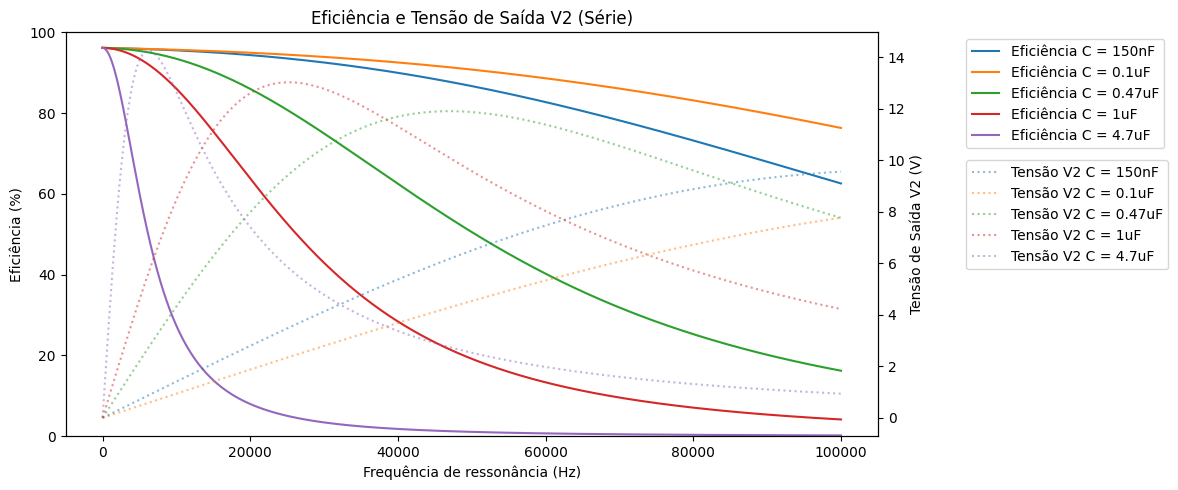

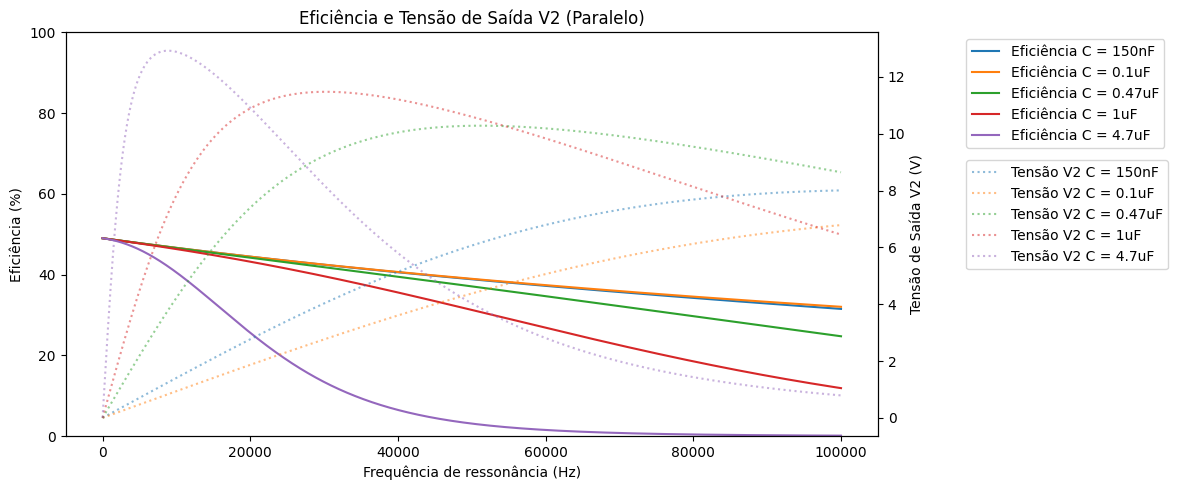

In [104]:
# Figura 1: Eficiência e Tensão de Saída (Série)
fig2, ax2 = plt.subplots(figsize=(12, 5))

# Eixo da esquerda (Eficiência)
for i, c in enumerate(Cs):
    ax2.plot(fs, resultados_serie[c]['n'], linestyle='-', label=f'Eficiência C = {Cs_labels[i]}')
ax2.set_xlabel('Frequência de ressonância (Hz)')
ax2.set_ylabel('Eficiência (%)')
ax2.set_title('Eficiência e Tensão de Saída V2 (Série)')
ax2.set_ylim(0, 100)

# Criando o segundo eixo y para a tensão de saída
ax2_2 = ax2.twinx()
for i, c in enumerate(Cs):
    ax2_2.plot(fs, resultados_serie[c]['V2'], alpha=0.5, linestyle='dotted', label=f'Tensão V2 C = {Cs_labels[i]}')
ax2_2.set_ylabel('Tensão de Saída V2 (V)')

# Movendo as legendas para a direita do gráfico
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2_2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.7))

# Ajustando o layout da segunda figura
fig2.tight_layout()
plt.show()



# Figura 2: Eficiência e Tensão de Saída (Paralelo)
fig1, ax1 = plt.subplots(figsize=(12, 5))

# Eixo da esquerda (Eficiência)
for i, c in enumerate(Cs):
    ax1.plot(fs, resultados_paralelo[c]['n'], linestyle='-', label=f'Eficiência C = {Cs_labels[i]}')
ax1.set_xlabel('Frequência de ressonância (Hz)')
ax1.set_ylabel('Eficiência (%)')
ax1.set_title('Eficiência e Tensão de Saída V2 (Paralelo)')
ax1.set_ylim(0, 100)

# Criando o segundo eixo y para a tensão de saída
ax1_2 = ax1.twinx()
for i, c in enumerate(Cs):
    ax1_2.plot(fs, resultados_paralelo[c]['V2'], alpha=0.5, linestyle='dotted', label=f'Tensão V2 C = {Cs_labels[i]}')
ax1_2.set_ylabel('Tensão de Saída V2 (V)')

# Movendo as legendas p  ara a direita do gráfico
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax1_2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.7))

# Ajustando o layout da primeira figura
fig1.tight_layout()
plt.show()

### Calculando os resultados de V2 e eficiência para cada configuração de capacitores
(Variando a frequência, valores, em série ou em paralelo)

In [105]:
resultados_serie = {}
resultados_paralelo = {}
V1 = 4.5*(2/(np.pi))
Rc = 20

for c in Cs:
    V2s_serie = []
    ns_serie = []
    
    V2s_paralelo = []
    ns_paralelo = []
    
    # Calculando para cada frequência
    for f in fs:
        # Calculando para transformador em série
        i1, i2 = CalcularTransformadorSerie(V1, c, f)
        
        # Calculando V2 e eficiência
        V2 = i2*Rc
        s1 = V1*i1.conjugate()/2
        s2 = V2*i2.conjugate()/2
        n = np.real(s2)/np.real(s1)
        
        V2s_serie.append(abs(V2))
        ns_serie.append(n*100)
        resultados_serie[c] = {"V2": V2s_serie, "n": ns_serie}
        
        # Calculando para transformador em paralelo
        i1, i2, Zeq_C2_RC, i_rc = CalcularTransformadorParalelo(V1, c, f)
        
        # Calculando V2 e eficiência
        V2 = i2*Zeq_C2_RC
        s1 = V1*i1.conjugate()/2
        s2 = V2*i_rc.conjugate()/2
        n = np.real(s2)/np.real(s1)
        
        V2s_paralelo.append(abs(V2))
        ns_paralelo.append(n*100)
        resultados_paralelo[c] = {"V2": V2s_paralelo, "n": ns_paralelo}

## Resultados das simulações

### Gerando os gráficos

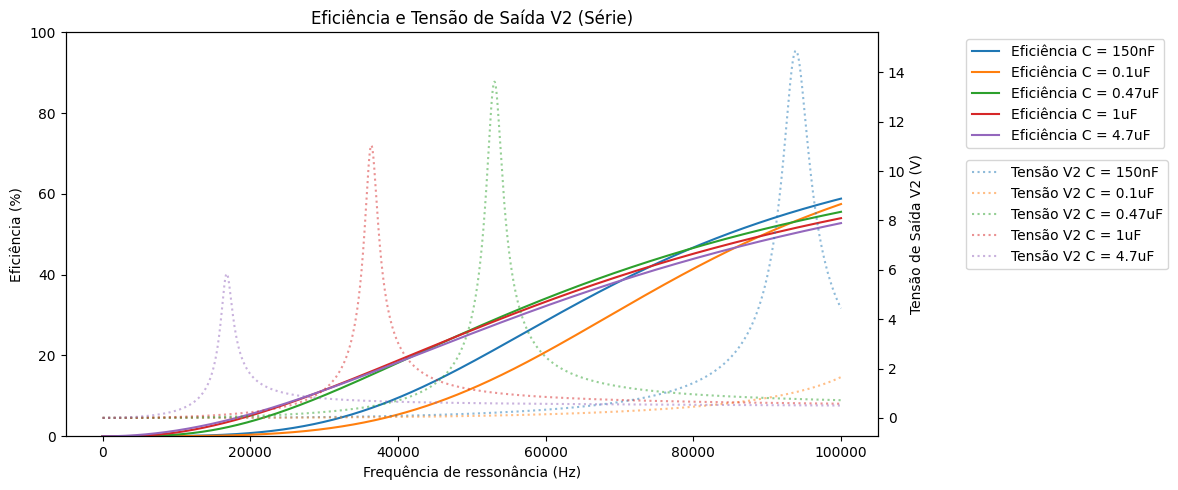

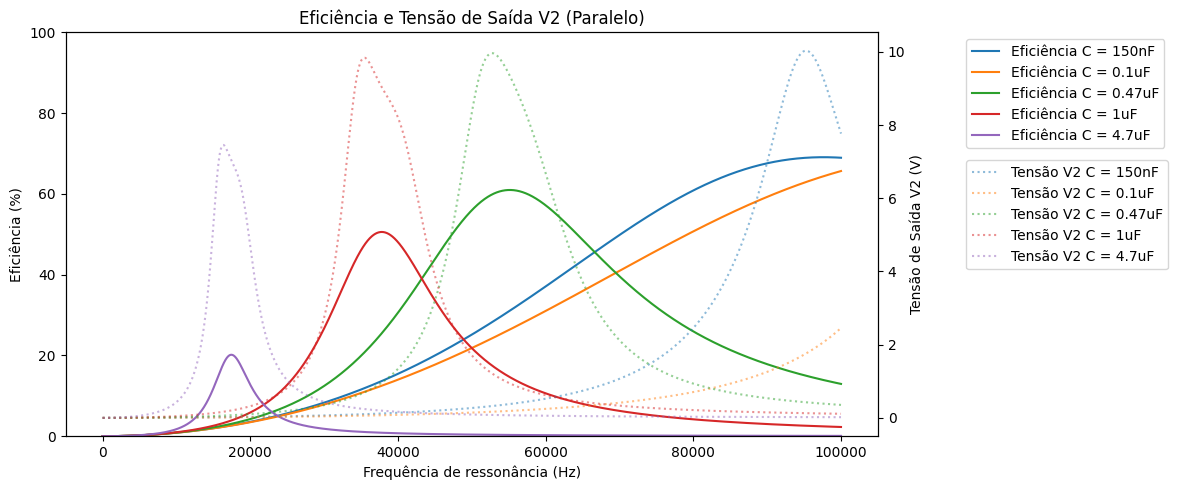

In [106]:
# Figura 1: Eficiência e Tensão de Saída (Série)
fig2, ax2 = plt.subplots(figsize=(12, 5))

# Eixo da esquerda (Eficiência)
for i, c in enumerate(Cs):
    ax2.plot(fs, resultados_serie[c]['n'], linestyle='-', label=f'Eficiência C = {Cs_labels[i]}')
ax2.set_xlabel('Frequência de ressonância (Hz)')
ax2.set_ylabel('Eficiência (%)')
ax2.set_title('Eficiência e Tensão de Saída V2 (Série)')
ax2.set_ylim(0, 100)

# Criando o segundo eixo y para a tensão de saída
ax2_2 = ax2.twinx()
for i, c in enumerate(Cs):
    ax2_2.plot(fs, resultados_serie[c]['V2'], alpha=0.5, linestyle='dotted', label=f'Tensão V2 C = {Cs_labels[i]}')
ax2_2.set_ylabel('Tensão de Saída V2 (V)')

# Movendo as legendas para a direita do gráfico
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2_2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.7))

# Ajustando o layout da segunda figura
fig2.tight_layout()
plt.show()



# Figura 2: Eficiência e Tensão de Saída (Paralelo)
fig1, ax1 = plt.subplots(figsize=(12, 5))

# Eixo da esquerda (Eficiência)
for i, c in enumerate(Cs):
    ax1.plot(fs, resultados_paralelo[c]['n'], linestyle='-', label=f'Eficiência C = {Cs_labels[i]}')
ax1.set_xlabel('Frequência de ressonância (Hz)')
ax1.set_ylabel('Eficiência (%)')
ax1.set_title('Eficiência e Tensão de Saída V2 (Paralelo)')
ax1.set_ylim(0, 100)

# Criando o segundo eixo y para a tensão de saída
ax1_2 = ax1.twinx()
for i, c in enumerate(Cs):
    ax1_2.plot(fs, resultados_paralelo[c]['V2'], alpha=0.5, linestyle='dotted', label=f'Tensão V2 C = {Cs_labels[i]}')
ax1_2.set_ylabel('Tensão de Saída V2 (V)')

# Movendo as legendas p  ara a direita do gráfico
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax1_2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.7))

# Ajustando o layout da primeira figura
fig1.tight_layout()
plt.show()

### Descobrindo a frequência ideal

Frequência com maior eficiência: 55141.0


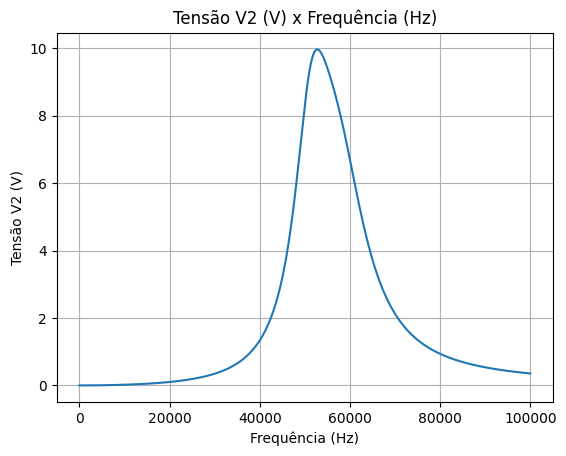

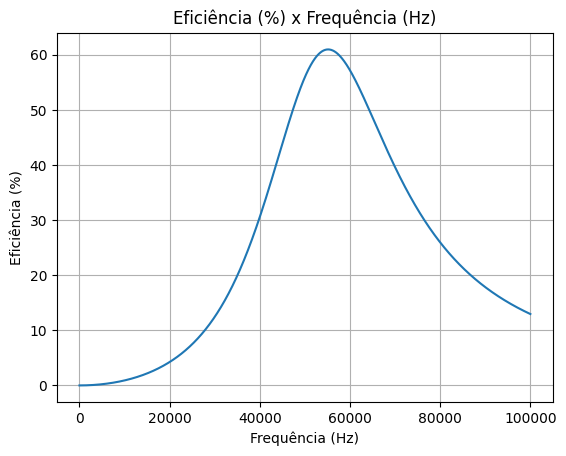

In [107]:
lista = []
lista_n = []
maior = 0
f_maior = 0
V1 = 4.5*(2/(np.pi))
for f in fs:
    i1, i2, Zeq_C2_RC, i_rc = CalcularTransformadorParalelo(
        V1, 0.47*1e-6, f)

    # Calculando V2 e eficiência
    V2 = i2*Zeq_C2_RC
    s1 = V1*i1.conjugate()/2
    s2 = V2*i_rc.conjugate()/2
    n = np.real(s2)/np.real(s1)

    lista_n.append(n)

    if maior < n:
        maior = n
        f_maior = f
    lista.append(abs(V2))


print(f"Frequência com maior eficiência: {f_maior}")

plt.plot(fs, lista)
plt.title('Tensão V2 (V) x Frequência (Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Tensão V2 (V)')
plt.grid()
plt.show()

plt.plot(fs, [n * 100 for n in lista_n])
plt.title('Eficiência (%) x Frequência (Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Eficiência (%)')
plt.grid()
plt.show()

### Valores da simulação

In [108]:
V1 = 6*(2/(np.pi))
i1, i2, Zeq_C2_RC, i_rc = CalcularTransformadorParalelo(V1, 0.47*1e-6, f_maior)

# Calculando V2 e eficiência
V2 = i2*Zeq_C2_RC
s1 = V1*i1.conjugate()/2
s2 = V2*i_rc.conjugate()/2
n = np.real(s2)/np.real(s1)

print(f"Frequência com maior eficiência: {f_maior}")
print(f"i1: {abs(i1)}")
print(f"i2: {abs(i2)}")
print(f"V2: {abs(V2)}")
print(f"n: {n*100}%")

Frequência com maior eficiência: 55141.0
i1: 3.4738473146308424
i2: 2.123098140361625
V2: 12.463866774822192
n: 60.968846583675976%


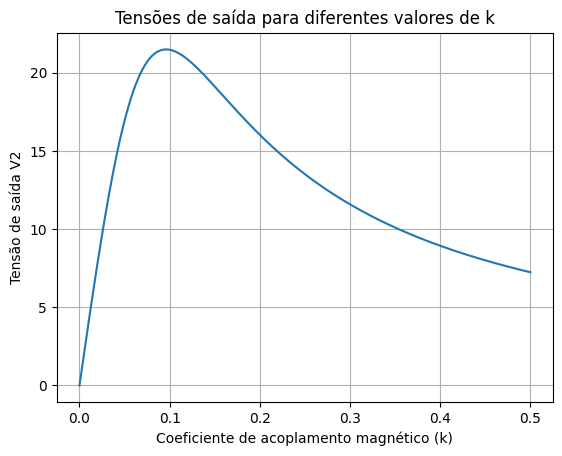

In [109]:
Rc = 100
V1 = 6*(2/(np.pi))
ks = np.arange(0, 0.5, 1e-4)
V2s = []
for k in ks:
    i1, i2, Zeq_C2_RC, i_rc = CalcularTransformadorParalelo(V1, 0.47*1e-6, 55000)
    
    # Calculando V2 e eficiência
    V2 = i2*Zeq_C2_RC
    V2s.append(abs(V2))

plt.plot(ks, V2s)
plt.title("Tensões de saída para diferentes valores de k")
plt.xlabel("Coeficiente de acoplamento magnético (k)")
plt.ylabel("Tensão de saída V2")
plt.grid()
plt.show()